In [2]:
from snowflake.snowpark import Session
import tomllib
import os

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
with open(os.environ["SNOWFLAKE_TOML"], "rb") as f:
    
    config = tomllib.load(f)  # Python >=3.11

# Get wallet classification connection details
wallet_classification_config = config["connections"]["wallet_classification"]

# Replace placeholders with environment variable values
conn_params = {k: os.path.expandvars(v) for k, v in wallet_classification_config.items()}

# Create Snowpark session
session = Session.builder.configs(conn_params).create()

# Test connection
print(f"Current Snowflake Role: {session.sql('SELECT CURRENT_ROLE()').collect()[0][0]}, Current Schema: {session.sql('SELECT CURRENT_SCHEMA()').collect()[0][0]}")

Current Snowflake Role: ACCOUNTADMIN, Current Schema: None


In [5]:
session.use_schema("ANALYTICS")

In [6]:
df=session.table("WALLET_CLASSIFICATION")
df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ADDRESS"                                    |"ACTIVE_DAYS"  |"TOTAL_TX_COUNT"  |"TOTAL_INCOMING_TX"  |"TOTAL_OUTGOING_TX"  |"LIFETIME_RECEIVED_LTC"  |"LIFETIME_SENT_LTC"  |"TOTAL_FEES_PAID_LTC"  |"CURRENT_BALANCE_LTC"  |"AVG_TX_PER_DAY"  |"AVG_RECEIVED_PER_DAY"  |"AVG_SENT_PER_DAY"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|ltc1qc4ls27z2ak2qf6y9luh34a592jhjmurayvp785  |1              |2                 |1                    |1                    |43582860  

In [7]:
#%pip install "snowflake-connector-python[pandas]"
df_wallet=df.to_pandas()
df_wallet.head()

,ADDRESS,ACTIVE_DAYS,TOTAL_TX_COUNT,TOTAL_INCOMING_TX,TOTAL_OUTGOING_TX,LIFETIME_RECEIVED_LTC,LIFETIME_SENT_LTC,TOTAL_FEES_PAID_LTC,CURRENT_BALANCE_LTC,AVG_TX_PER_DAY,AVG_RECEIVED_PER_DAY,AVG_SENT_PER_DAY
0,ltc1qqwt0rh2mt92pzgd03hmne27hldhx6s8k80vd8y,1,2,1,1,10350000,10350000,432,0,2.0,1.035000e+07,1.035000e+07
1,MS3ghfFBkSrNKqtsSXeqeve93zjGMnM34c,1,2,1,1,3170160,3170160,2560,0,2.0,3.170160e+06,3.170160e+06
2,MVJsSEJC338LwHrg1xrZ6SUUprDiM9zndG,1,4,3,1,475381263,158460421,2633,0,4.0,4.753813e+08,1.584604e+08
3,ltc1q6w8h962edrwef3kcf2vt05l07n76wraueud9n5,1,2,1,1,18300000,18300000,141,0,2.0,1.830000e+07,1.830000e+07
4,ltc1q4hxzgckef89auxwqlkd2g8c60ekup494u4euh4,1,2,1,1,2575676118,2575676118,274,0,2.0,2.575676e+09,2.575676e+09


In [8]:
df_wallet_clean=df_wallet.dropna()

In [9]:
# Display basic information about the dataset
print("Dataset Overview:")
print(f"Total wallets: {len(df_wallet_clean):,}")
print(f"Columns available: {list(df_wallet_clean.columns)}")

# Check data types and missing values
print("\nData Info:")
print(df_wallet_clean.info())

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(df_wallet_clean.describe())

# Check for any remaining missing values after cleaning
print(f"\nMissing values per column:")
print(df_wallet_clean.isnull().sum())

Dataset Overview:
Total wallets: 5,883,412
Columns available: ['ADDRESS', 'ACTIVE_DAYS', 'TOTAL_TX_COUNT', 'TOTAL_INCOMING_TX', 'TOTAL_OUTGOING_TX', 'LIFETIME_RECEIVED_LTC', 'LIFETIME_SENT_LTC', 'TOTAL_FEES_PAID_LTC', 'CURRENT_BALANCE_LTC', 'AVG_TX_PER_DAY', 'AVG_RECEIVED_PER_DAY', 'AVG_SENT_PER_DAY']

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5883412 entries, 0 to 5883411
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ADDRESS                object 
 1   ACTIVE_DAYS            int8   
 2   TOTAL_TX_COUNT         int32  
 3   TOTAL_INCOMING_TX      int32  
 4   TOTAL_OUTGOING_TX      int32  
 5   LIFETIME_RECEIVED_LTC  int64  
 6   LIFETIME_SENT_LTC      int64  
 7   TOTAL_FEES_PAID_LTC    int32  
 8   CURRENT_BALANCE_LTC    int64  
 9   AVG_TX_PER_DAY         float64
 10  AVG_RECEIVED_PER_DAY   float64
 11  AVG_SENT_PER_DAY       float64
dtypes: float64(3), int32(4), int64(3), int8(1), object(1)
memory us

In [10]:
features = [
    "ACTIVE_DAYS",
    "TOTAL_TX_COUNT",
    "TOTAL_OUTGOING_TX",
    "LIFETIME_SENT_LTC",
    "LIFETIME_RECEIVED_LTC",
    "CURRENT_BALANCE_LTC",
    "AVG_SENT_PER_DAY",
    "AVG_RECEIVED_PER_DAY"
]

# Verify all features exist in the dataframe
missing_features = [f for f in features if f not in df_wallet_clean.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")

# Select features and handle any potential issues
X = df_wallet_clean[features].copy()

# Optional: Check for any remaining NaN values after cleaning
if X.isnull().sum().sum() > 0:
    print("Warning: Found NaN values in features, filling with median values")
    X = X.fillna(X.median())

print(f"Feature matrix shape: {X.shape}")
print(f"Features selected: {features}")

Feature matrix shape: (5883412, 8)
Features selected: ['ACTIVE_DAYS', 'TOTAL_TX_COUNT', 'TOTAL_OUTGOING_TX', 'LIFETIME_SENT_LTC', 'LIFETIME_RECEIVED_LTC', 'CURRENT_BALANCE_LTC', 'AVG_SENT_PER_DAY', 'AVG_RECEIVED_PER_DAY']


In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [12]:
# Initialize the models
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

kmeans = KMeans(n_clusters=3, random_state=42)
scaler = StandardScaler()

# Scale numeric features
X_scaled = scaler.fit_transform(X)

# Cluster into 3 groups and assign using .loc to avoid warning
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_wallet_clean['cluster'] = kmeans.fit_predict(X_scaled)

centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features
)
# Assuming df_wallet_clean contains your final data with 'cluster' column
output_path = "wallet_cluster_results.csv"

# Save to CSV
df_wallet_clean.to_csv(output_path, index=False)

print(f"Data successfully saved to {output_path}")

Data successfully saved to wallet_cluster_results.csv


In [13]:
result_df=pd.read_csv("wallet_cluster_results.csv")
result_df.head()

,ADDRESS,ACTIVE_DAYS,TOTAL_TX_COUNT,TOTAL_INCOMING_TX,TOTAL_OUTGOING_TX,LIFETIME_RECEIVED_LTC,LIFETIME_SENT_LTC,TOTAL_FEES_PAID_LTC,CURRENT_BALANCE_LTC,AVG_TX_PER_DAY,AVG_RECEIVED_PER_DAY,AVG_SENT_PER_DAY,cluster
0,ltc1qqwt0rh2mt92pzgd03hmne27hldhx6s8k80vd8y,1,2,1,1,10350000,10350000,432,0,2.0,1.035000e+07,1.035000e+07,0
1,MS3ghfFBkSrNKqtsSXeqeve93zjGMnM34c,1,2,1,1,3170160,3170160,2560,0,2.0,3.170160e+06,3.170160e+06,0
2,MVJsSEJC338LwHrg1xrZ6SUUprDiM9zndG,1,4,3,1,475381263,158460421,2633,0,4.0,4.753813e+08,1.584604e+08,0
3,ltc1q6w8h962edrwef3kcf2vt05l07n76wraueud9n5,1,2,1,1,18300000,18300000,141,0,2.0,1.830000e+07,1.830000e+07,0
4,ltc1q4hxzgckef89auxwqlkd2g8c60ekup494u4euh4,1,2,1,1,2575676118,2575676118,274,0,2.0,2.575676e+09,2.575676e+09,0


In [14]:
#silhouette = silhouette_score(X_scaled, df_wallet_clean["cluster"])
calinski = calinski_harabasz_score(X_scaled, df_wallet_clean["cluster"])
#davies = davies_bouldin_score(X_scaled, df_wallet_clean["cluster"])

#print("\n=== KMeans Clustering Metrics ===")
#print(f"Silhouette Score:        {silhouette:.3f}  (higher is better, max=1)")
print(f"Calinski-Harabasz Score: {calinski:.3f}  (higher is better)")
#print(f"Davies-Bouldin Score:    {davies:.3f}  (lower is better)")

Calinski-Harabasz Score: 3033342.890  (higher is better)


In [15]:
# Labelling clusters  
cluster_labels = {}

# Normalize values to compare across metrics
centers_norm = centers.copy()
for col in ["CURRENT_BALANCE_LTC", "TOTAL_TX_COUNT", "ACTIVE_DAYS"]:
    centers_norm[col] = (centers_norm[col] - centers_norm[col].min()) / (centers_norm[col].max() - centers_norm[col].min())

for i, row in centers_norm.iterrows():
    # Weighted importance (you can tweak)
    balance_score = row["CURRENT_BALANCE_LTC"] * 0.5
    tx_score = row["TOTAL_TX_COUNT"] * 0.3
    activity_score = row["ACTIVE_DAYS"] * 0.2

    # Combine to decide wallet type
    if balance_score == max(balance_score, tx_score, activity_score):
        cluster_labels[i] = "Whale Wallets"
    elif tx_score == max(balance_score, tx_score, activity_score):
        cluster_labels[i] = "Exchange/Merchant Wallets"
    else:
        cluster_labels[i] = "Small/Individual Wallets"

# Ensure unique labels — if any duplicates remain, assign based on rank
if len(set(cluster_labels.values())) < 3:
    sorted_clusters = centers.assign(
        score=centers["CURRENT_BALANCE_LTC"] + centers["TOTAL_TX_COUNT"]
    ).sort_values("score")
    unique_labels = ["Small/Individual Wallets", "Exchange/Merchant Wallets", "Whale Wallets"]
    for label, cluster_id in zip(unique_labels, sorted_clusters.index):
        cluster_labels[cluster_id] = label

# Assign labels to dataset
df_wallet_clean["wallet_category"] = df_wallet_clean["cluster"].map(cluster_labels)

print("\n=== AUTOMATIC LABEL MAPPING ===")
print(cluster_labels)



=== AUTOMATIC LABEL MAPPING ===
{0: 'Small/Individual Wallets', 1: 'Whale Wallets', 2: 'Exchange/Merchant Wallets'}


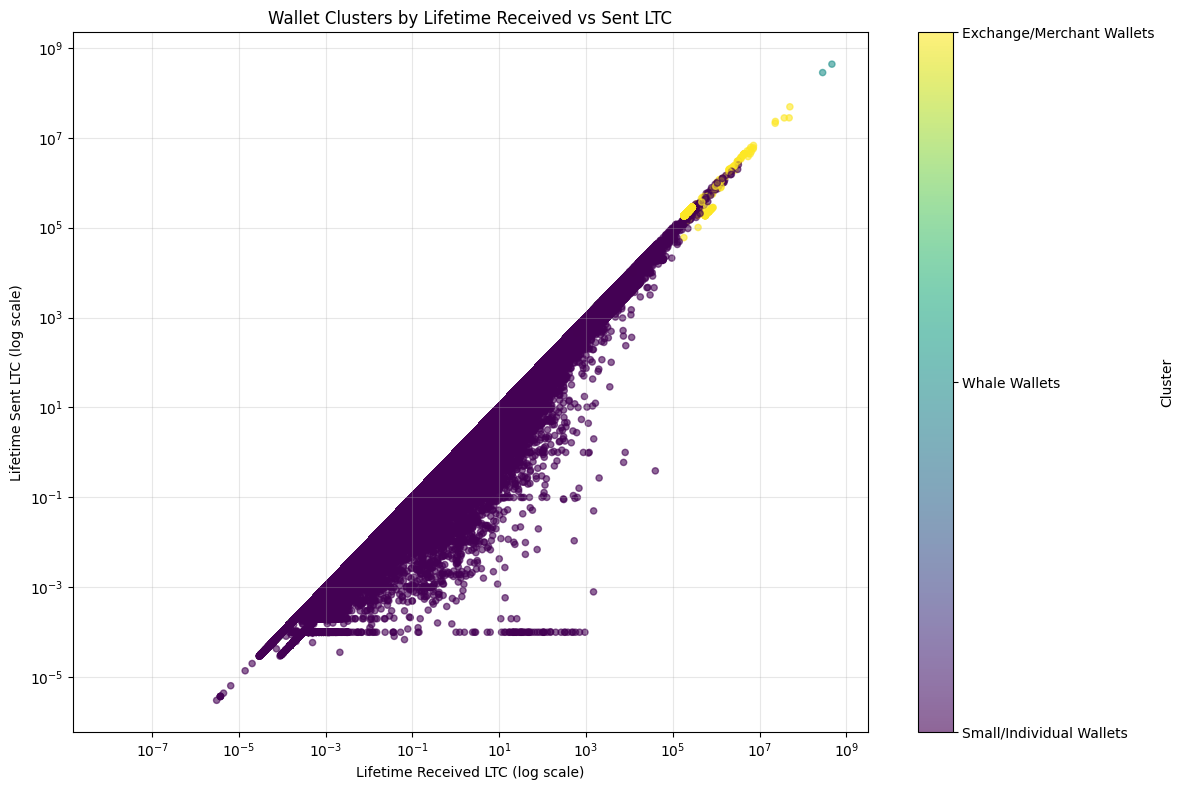

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

x = df_wallet_clean['LIFETIME_RECEIVED_LTC']/1e8
y = df_wallet_clean['LIFETIME_SENT_LTC']/1e8
c = df_wallet_clean['cluster']

scatter = plt.scatter(x, y, c=c, cmap='viridis', alpha=0.6, s=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Lifetime Received LTC (log scale)")
plt.ylabel("Lifetime Sent LTC (log scale)")
plt.title("Wallet Clusters by Lifetime Received vs Sent LTC")

# Create colorbar with dynamic labels
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Sort clusters for consistent color mapping
sorted_clusters = sorted(cluster_labels.keys())
sorted_labels = [cluster_labels[i] for i in sorted_clusters]
cbar.set_ticks(sorted_clusters)
cbar.set_ticklabels(sorted_labels)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# Display cluster statistics
print("\n=== CLUSTER STATISTICS ===")
print(f"Total wallets analyzed: {len(df_wallet_clean):,}")
print("\nCluster distribution:")
cluster_counts = df_wallet_clean['wallet_category'].value_counts()
for category, count in cluster_counts.items():
    #percentage = (count / len(df_wallet_clean)) * 100
    print(f"  {category}: {count:,}")

print("\nCluster summary statistics:")
print(df_wallet_clean.groupby('wallet_category')[['LIFETIME_RECEIVED_LTC', 'LIFETIME_SENT_LTC', 'CURRENT_BALANCE_LTC', 'ACTIVE_DAYS']].agg(['mean', 'median', 'std']).round(2))



=== CLUSTER STATISTICS ===
Total wallets analyzed: 5,883,412

Cluster distribution:
  Small/Individual Wallets: 5,863,494
  Exchange/Merchant Wallets: 19,916
  Whale Wallets: 2

Cluster summary statistics:
                          LIFETIME_RECEIVED_LTC                              \
                                           mean        median           std   
wallet_category                                                               
Exchange/Merchant Wallets          2.362885e+13  1.920602e+13  6.301981e+13   
Small/Individual Wallets           2.822581e+09  4.384100e+07  3.915524e+11   
Whale Wallets                      3.743324e+16  3.743324e+16  1.274657e+16   

                          LIFETIME_SENT_LTC                              \
                                       mean        median           std   
wallet_category                                                           
Exchange/Merchant Wallets      2.326361e+13  1.920547e+13  5.220705e+13   
Small/Individual W